Hello, I am JYC. This notebook implements all the sub-tasks in experimental topic 1. I will explain the logic behind each concept to assist students who are not proficient in coding to quickly grasp the key points and complete the experiment.

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Graph Generation

Here, I have defined four functions for generating networks: 
1. Globally coupled network `global_network`
2. Nearest-neighbor coupled network `nearest_neighbor_network`
3. Star coupled network `star_network`
4. Random network `random_network`

In [6]:
def global_network(num_nodes: int):
    g = nx.Graph()
    g.add_edges_from(np.vstack(np.triu_indices(num_nodes, k=1)).T)
    return g


def nearest_neighbor_network(num_nodes: int, k: int):
    assert k % 2 == 0, "K must be an even number"

    g = nx.Graph()
    nodes = list(range(num_nodes))
    for j in range(1, k // 2 + 1):
        g.add_edges_from(zip(nodes, nodes[j:] + nodes[0:j]))
    return g


def star_network(num_nodes: int):
    g = nx.Graph()
    g.add_edges_from(
        np.vstack([np.repeat(0, num_nodes - 1), np.arange(1, num_nodes)]).T
    )
    return g


def random_network(num_nodes: int, p: float):
    assert 0 <= p <= 1, "Probability p must be between 0 and 1."

    g = nx.Graph()
    upper_tri = np.triu(np.random.rand(num_nodes, num_nodes), 1)
    upper_tri[upper_tri < p] = 1
    upper_tri[upper_tri != 1] = 0
    g.add_edges_from(np.column_stack(np.where((upper_tri + upper_tri.T) == 1)))

    return g

## Metric Calculation

Additionally, we need to implement functions to calculate the average shortest path length and the clustering coefficient. Of course, we can also directly use `nx.single_source_shortest_path_length` and `nx.average_clustering` from the networkx library.

### Average Shortest Path Length
For calculating the average shortest path length, it is necessary to determine the all-pairs shortest paths. Since the graphs we generate are unweighted, we can simply use **Breadth-First Search** (BFS) on each node for `num_nodes` times. For simplicity, in this step, we will directly utilize `nx.single_source_shortest_path_length`. If the graph were weighted, for positive weights, we would use **Dijkstra**'s algorithm or the **Floyd-Warshall** algorithm, and for negative weights, we could use the **SPFA** algorithm or **Johnson**'s algorithm.

After we get shortest path length of each node, we can apply the following formula to get the result.
$$
L = \sum_{\substack{s,t \in V \\ s\neq t}} \frac{d(s, t)}{n(n-1)}
$$
 where `V` is the set of nodes in `G`, `d(s, t)` is the shortest path from `s` to `t`, and `n` is the number of nodes in `G`.


In [7]:
def average_shortest_path_length(g):
    n = len(g)
    return sum(
        l for s in g for l in nx.single_source_shortest_path_length(g, s).values()
    ) / (n * (n - 1))

### Clustering Coefficient
The clustering coefficient is a metric that describes the degree of local compactness around a vertex in a graph. To calculate the average clustering coefficient, we need to compute the clustering coefficient $C_u$, for each vertex and then take the average of these values.

The formula of clustering coefficient of one node `u` is as follows:
$$
      C_u = \frac{2 T(u)}{deg(u)(deg(u)-1)}
$$
where `T(u)` is the number of triangles through node `u` and `deg(u)` is the degree of `u`.

To calculate the clustering coefficient for a vertex  `u`  in a graph, we need to consider the number of triangles that  u  forms with its neighbors. Let's take vertex  `B`  as an example for  `u` , with neighbors  `u_nbrs = {A, C, D, E}` .

For each neighbor `v` of  `u` (for instance,  `v = C` ), we find  `v` 's neighbors (which are  `{A, B, E}`  in this example). We then take the intersection of  `u`'s neighbors and  `v`'s neighbors. The resulting nodes from this intersection are those that can form triangles with both `u` and `v`.
<div align="center">
<pre>
  A
 / \
  B---C
 / \ / \
D   E   F
</pre>
</div>


In [8]:
from collections import Counter


def average_clustering(g):
    def triangle_degree_iter(): 
        for u, u_nbrs in g.adj.items():
            u_nbrs = set(u_nbrs) - {u}  # remove self-loop if exists
            gen_degree = Counter(len(u_nbrs & (set(g[v]) - {v})) for v in u_nbrs)
            num_triangles = sum(k * val for k, val in gen_degree.items())
            yield (len(u_nbrs), num_triangles)

    return sum(
        0 if T == 0 else T / (deg * (deg - 1)) for deg, T in triangle_degree_iter()
    ) / len(g)

## Graph Visualization

Now that we've completed all the preparations, let's proceed to visualize each network. We'll use visual representation to better understand the structure and connectivity of each network type, including the globally coupled network, nearest-neighbor coupled network, star network, and random network. For this visualization, tools like NetworkX in combination with matplotlib or similar libraries can be employed to generate clear and informative graphs. These visualizations will help illustrate the differences and unique characteristics of each network configuration.

In [9]:
num_nodes = 10
k = 4  # for nearest neighbor coupled network
p = 0.5  # for random network


def show_graph(g):
    nx.draw(g, pos=nx.circular_layout(g))
    plt.show()
    # verify the correctness of our implementation
    assert average_shortest_path_length(g) == nx.average_shortest_path_length(g)
    assert average_clustering(g) == nx.average_clustering(g)

    print(f"Average shortest path length: {average_shortest_path_length(g)}")
    print(f"Average clustering coefficient: {average_clustering(g)}")

### Globally Coupled Network
This is a network where every pair of distinct vertices is connected by a unique edge. Visualization of this network will show a dense web of connections with each node directly linked to every other node.

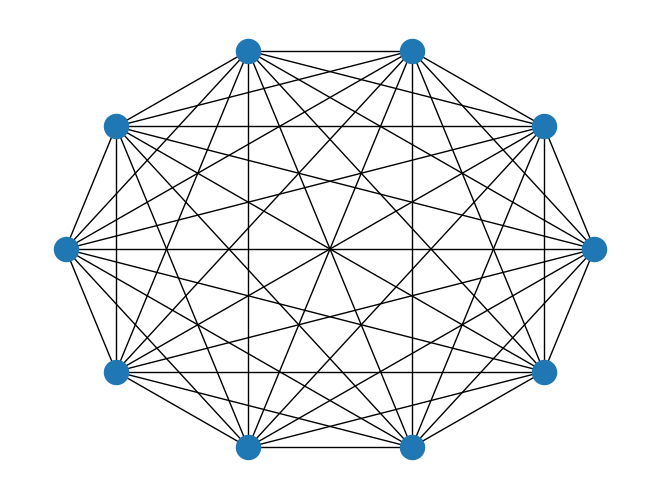

Average shortest path length: 1.0
Average clustering coefficient: 1.0


In [10]:
show_graph(global_network(num_nodes))

### Nearest Neighbor Coupled Network

In this network, each node is connected to `K` neighbors, `K/2` on each side, assuming `K` is an even number. Visualizing this network typically displays a circular or linear layout where nodes are visibly connected to their immediate neighbors, creating a ring-like or chain structure depending on the layout choice.

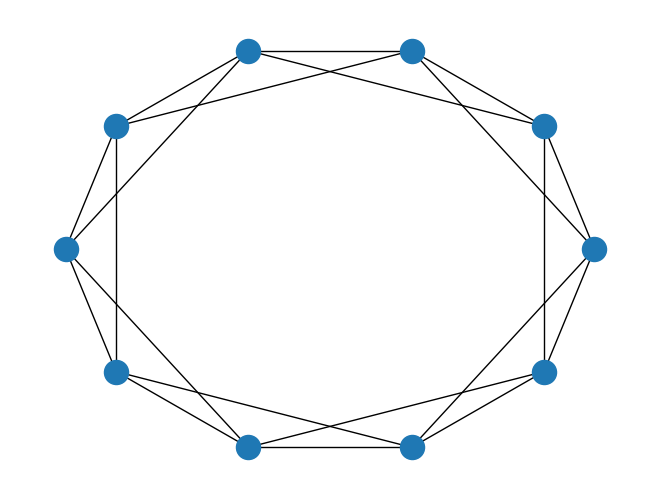

Average shortest path length: 1.6666666666666667
Average clustering coefficient: 0.5


In [11]:
show_graph(nearest_neighbor_network(num_nodes, k))

### Star Coupled Network

This network features a central hub node connected to all other nodes, which only connect to this hub and not to each other. The visualization will show a central node with spokes radiating out to peripheral nodes, clearly highlighting the hub-and-spoke topology.

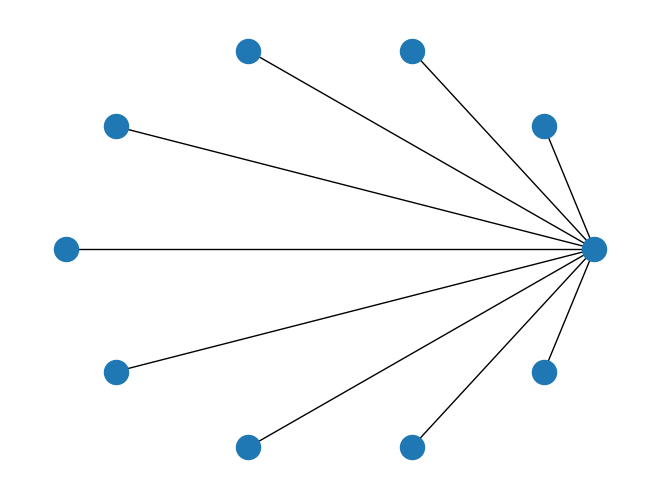

Average shortest path length: 1.8
Average clustering coefficient: 0.0


In [12]:
show_graph(star_network(num_nodes))

### Random Network

In this network, each pair of nodes has a probability `p` of being connected. This results in a network where connections are made randomly. The visualization might show a scattered pattern of edges that do not follow a clear regular structure, reflecting the randomness in connectivity.

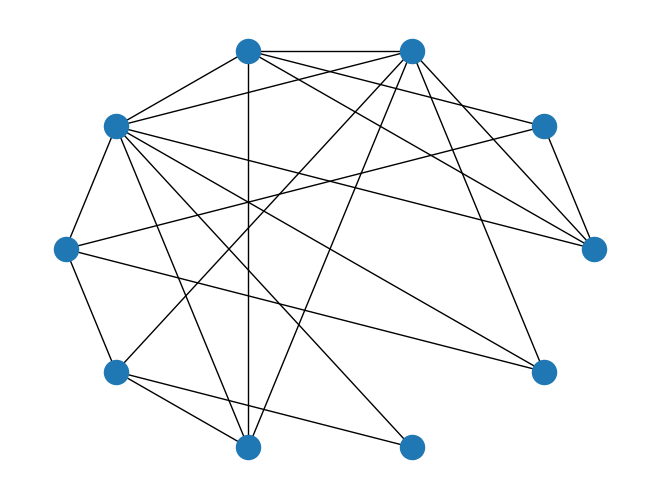

Average shortest path length: 1.5555555555555556
Average clustering coefficient: 0.4066666666666666


In [13]:
show_graph(random_network(num_nodes, p))